In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [8]:
file_path = '/content/drive/MyDrive/ds/Sleep_health_and_lifestyle_dataset.csv'

try:
    # Load data
    df = pd.read_csv(file_path)
    print(f"Successfully loaded data from {file_path}")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please double-check the path.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

Successfully loaded data from /content/drive/MyDrive/ds/Sleep_health_and_lifestyle_dataset.csv


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea


In [9]:
"""
Project: Manō - Component 2: Cognitive Risk Prediction System

Description:
    This component implements a Multi-Task LSTM with Temporal Attention
    to predict Cognitive Risk levels based on physiological biomarkers.

    Unlike standard binary models, this system classifies risk into
    THREE distinct levels to enable granular intervention:
    1. Low Risk (Safe)      -> Maintain Flow State
    2. Medium Risk (Warning)-> Suggest Micro-Breaks
    3. High Risk (Critical) -> Trigger Immediate Intervention

Novelty:
    - Usage of Temporal Attention to weigh historical data relevance.
    - Multi-class calibration
"""

# ==========================================
# 0. LIBRARIES & IMPORTS
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# ==========================================
# 1. CONFIGURATION (The Control Panel)
# ==========================================
TARGET_COLUMN = "Stress Level"

In [11]:
# ==========================================
# 2. DATA LOADING & PREPROCESSING
# ==========================================


# --- 2.1 CLEANING ---
# Rationale: 'Sleep Disorder' has missing values for healthy people.
# We fill these with 'None' to preserve data integrity.
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

# Rationale: 'Person ID' is an arbitrary counter (noise). Removing it prevents overfitting.
if 'Person ID' in df.columns:
    df = df.drop(columns=['Person ID'])

# Rationale: Neural Networks require numbers. We split '126/83' into two float columns.
if 'Blood Pressure' in df.columns:
    df[['BP_Sys', 'BP_Dia']] = df['Blood Pressure'].str.split('/', expand=True).astype(float)
    df = df.drop(columns=['Blood Pressure'])

# --- 2.2 ENCODING (Text -> Numbers) ---
# We save encoders in a dictionary so we can use them later for new patients.
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# --- 2.3 TARGET MAPPING (The 3-Class Logic) ---
# We map raw stress scores (3-8) into 3 Cognitive Risk Categories.
# Low Risk (0): Scores 3, 4     -> Optimal Cognitive Function
# Med Risk (1): Scores 5, 6     -> Cognitive Fatigue (Warning Zone)
# High Risk (2): Scores 7, 8    -> Cognitive Overload (Danger Zone)
print("   -> Mapping Target to 3 Levels (Low, Medium, High)...")
y_raw = df[TARGET_COLUMN].values
y = []
for val in y_raw:
    if val <= 4:
        y.append(0) # Low Risk
    elif val <= 6:
        y.append(1) # Medium Risk
    else:
        y.append(2) # High Risk
y = np.array(y)

# Validation: Check if classes are balanced
print(f"   -> Class Counts: Low={sum(y==0)}, Medium={sum(y==1)}, High={sum(y==2)}")

# --- 2.4 SCALING & RESHAPING ---
# Rationale: LSTM requires inputs in range 0-1.
X_raw = df.drop(columns=[TARGET_COLUMN]).values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

# Rationale: LSTM expects 3D input (Samples, TimeSteps, Features).
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split: 80% for Training, 20% for Testing
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y, test_size=0.2, random_state=42)


   -> Mapping Target to 3 Levels (Low, Medium, High)...
   -> Class Counts: Low=141, Medium=113, High=120


In [12]:

# ==========================================
# 3. MODEL ARCHITECTURE (LSTM + ATTENTION)
# ==========================================
print("\n>>> STEP 2: Building 3-Class Architecture...")

def build_multiclass_model(input_shape):
    """
    Constructs a Multi-Task LSTM capable of 3-class classification.
    """
    inputs = Input(shape=input_shape)

    # Layer 1: LSTM
    # Captures temporal dependencies in the biomarker data.
    # return_sequences=True is REQUIRED for the Attention mechanism.
    x = LSTM(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x) # Prevents overfitting

    # Layer 2: Temporal Attention (Novelty)
    # Dynamically weights important features/time-steps.
    attn = Attention()([x, x])
    x = GlobalAveragePooling1D()(attn)

    # Layer 3: Output Layer (Updated for 3 Classes)
    # 3 Neurons: One for each class (Low, Medium, High)
    # Activation 'softmax': Outputs probabilities that sum to 1.0 (e.g., [0.1, 0.7, 0.2])
    outputs = Dense(3, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="Mano_Risk_Model")

    # Compilation: Using 'sparse_categorical_crossentropy' for integer labels (0, 1, 2)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_multiclass_model((1, X_train.shape[2]))
model.summary()


>>> STEP 2: Building 3-Class Architecture...


Model: "Mano_Risk_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 12)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 1, 64)     │     19,712 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1, 64)     │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 1, 64)     │          0 │ dropout[0][0],    │
│ (Attention)         │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3)         │        195 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,907 (77.76 KB)

 Trainable params: 19,907 (77.76 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# ==========================================
# 4. TRAINING
# ==========================================
print("\n>>> STEP 3: Training Model...")

# Early Stopping: Stops training if validation loss doesn't improve for 10 epochs.
stopper = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=60,
                    batch_size=16,
                    callbacks=[stopper],
                    verbose=1)



>>> STEP 3: Training Model...
Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3973 - loss: 1.0919 - val_accuracy: 0.7333 - val_loss: 1.0595
Epoch 2/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5964 - loss: 1.0431 - val_accuracy: 0.6933 - val_loss: 1.0203
Epoch 3/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6976 - loss: 0.9847 - val_accuracy: 0.6933 - val_loss: 0.9787
Epoch 4/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6766 - loss: 0.9381 - val_accuracy: 0.7467 - val_loss: 0.9236
Epoch 5/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8017 - loss: 0.8830 - val_accuracy: 0.7600 - val_loss: 0.8594
Epoch 6/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8093 - loss: 0.8072 - val_accuracy: 0.7600 - val_loss: 0.7815
Epoch 7/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8248 - loss: 0.7455 - val_accuracy: 0.7600 - val_loss: 0.7014
Epoch 8/60
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8191 - loss: 0.6597 - val_accuracy: 0.7600 - val_loss: 0.6326
Ep


>>> STEP 4: Final Evaluation...
✅ Model Saved: 'risk_model_3class.keras'
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


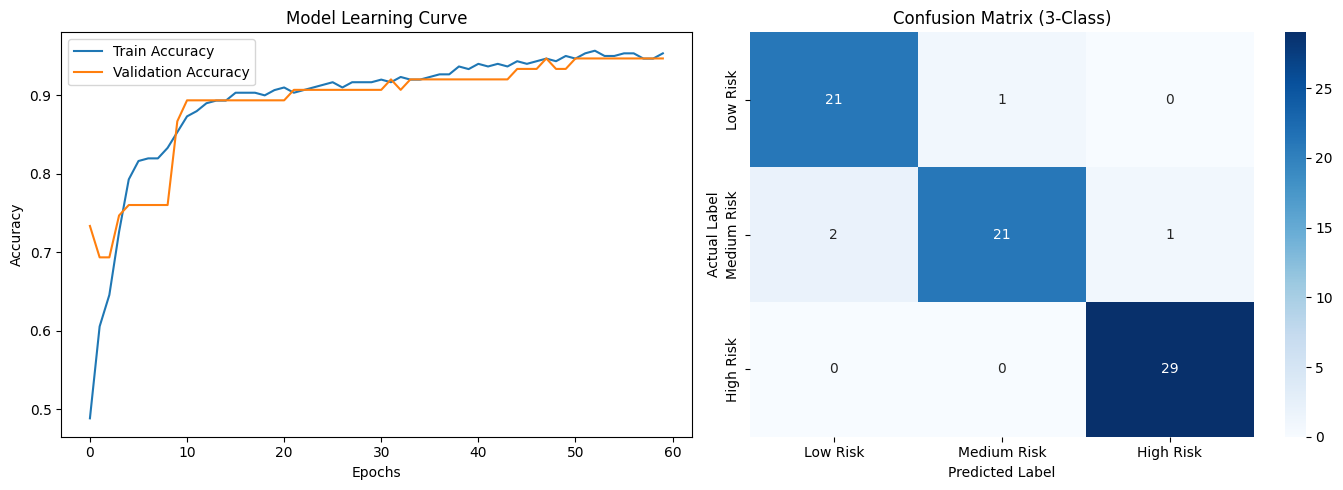


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

    Low Risk       0.91      0.95      0.93        22
 Medium Risk       0.95      0.88      0.91        24
   High Risk       0.97      1.00      0.98        29

    accuracy                           0.95        75
   macro avg       0.94      0.94      0.94        75
weighted avg       0.95      0.95      0.95        75



In [14]:
# ==========================================
# 5. EVALUATION
# ==========================================
print("\n>>> STEP 4: Final Evaluation...")

# Save the trained model artifact
model.save('risk_model_3class.keras')
print("✅ Model Saved: 'risk_model_3class.keras'")

# Generate Predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1) # Convert probabilities to class labels (0, 1, or 2)

# Visualization 1: Accuracy Curve
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Visualization 2: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low Risk', 'Medium Risk', 'High Risk'],
            yticklabels=['Low Risk', 'Medium Risk', 'High Risk'])
plt.title('Confusion Matrix (3-Class)')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Detailed Statistics
print("\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred, target_names=['Low Risk', 'Medium Risk', 'High Risk']))

In [18]:
# ==========================================
# 6. LIVE TEST (Try a Medium Risk Patient)
# ==========================================
print("\n>>> STEP 5: Live Testing a 'Medium Risk' Scenario...")

# We simulate a user who is "Tired but not Broken" (Stress Level ~6)
medium_risk_user = {
    'Gender': 'Male',
    'Age': 30,
    'Occupation': 'Teacher',
    'Sleep Duration': 7.2,          # Borderline sleep (Warning Zone)
    'Quality of Sleep': 8,          # Mediocre quality
    'Physical Activity Level': 55,  # Low activity
    'BMI Category': 'Normal Weight',
    'Blood Pressure': '119/77',     # Slightly elevated
    'Heart Rate': 73,               # Elevated HR
    'Daily Steps': 7300,            # Low steps
    'Sleep Disorder': 'None'
}

# Process the new user exactly like training data
input_df = pd.DataFrame([medium_risk_user])
if 'Blood Pressure' in input_df.columns:
    input_df[['BP_Sys', 'BP_Dia']] = input_df['Blood Pressure'].str.split('/', expand=True).astype(float)
    input_df = input_df.drop(columns=['Blood Pressure'])

for col, le in label_encoders.items():
    if col in input_df.columns:
        try:
            input_df[col] = le.transform(input_df[col])
        except:
            input_df[col] = 0 # Handle unknown categories

input_scaled = scaler.transform(input_df.values)
input_lstm = input_scaled.reshape((1, 1, input_scaled.shape[1]))

# Predict
probs = model.predict(input_lstm, verbose=0)[0]
prediction = np.argmax(probs)
class_names = ['LOW RISK 🟢', 'MEDIUM RISK 🟡', 'HIGH RISK 🔴']

print(f"--------------------------------")
print(f"User Scenario: {medium_risk_user['Occupation']}, Sleep: {medium_risk_user['Sleep Duration']}h")
print(f"Probabilities: Low: {probs[0]:.2f}, Med: {probs[1]:.2f}, High: {probs[2]:.2f}")
print(f"FINAL VERDICT: {class_names[prediction]}")
print(f"--------------------------------")


>>> STEP 5: Live Testing a 'Medium Risk' Scenario...
--------------------------------
User Scenario: Teacher, Sleep: 7.2h
Probabilities: Low: 0.12, Med: 0.88, High: 0.00
FINAL VERDICT: MEDIUM RISK 🟡
--------------------------------


In [19]:
# ==========================================
# TEST ON A BRAND NEW "UNSEEN" PATIENT
# ==========================================
import pandas as pd
import numpy as np

print("\n>>> SIMULATING NEW PATIENT...")

# 1. Define the New Patient (Change these numbers to test different scenarios)
# Scenario: A Stressed Nurse with bad sleep
new_patient = {
    'Gender': 'Female',
    'Age': 35,
    'Occupation': 'Nurse',            # High stress job
    'Sleep Duration': 5.5,            # Low sleep
    'Quality of Sleep': 5,            # Poor quality
    'Physical Activity Level': 70,    # High activity (on feet all day)
    'BMI Category': 'Overweight',
    'Blood Pressure': '130/85',       # High BP
    'Heart Rate': 90,                 # High HR
    'Daily Steps': 10000,             # High steps
    'Sleep Disorder': 'None'
}

# 2. Convert Dictionary to DataFrame (Just like the original CSV)
input_df = pd.DataFrame([new_patient])

# 3. Preprocessing (MUST match training exactly)
# A. Split Blood Pressure
if 'Blood Pressure' in input_df.columns:
    input_df[['BP_Sys', 'BP_Dia']] = input_df['Blood Pressure'].str.split('/', expand=True).astype(float)
    input_df = input_df.drop(columns=['Blood Pressure'])

# B. Encode Text (Gender, Job, etc.)
# We use the 'label_encoders' saved from your training step
for col, le in label_encoders.items():
    if col in input_df.columns:
        try:
            # Handle unknown labels (e.g., if you type 'Pilot', map to 0)
            if input_df[col].iloc[0] in le.classes_:
                input_df[col] = le.transform(input_df[col])
            else:
                input_df[col] = 0 # Default fallback
        except:
            pass

# C. Scale the numbers (0 to 1)
# We use the 'scaler' saved from training
input_scaled = scaler.transform(input_df.values)

# D. Reshape for LSTM (1 Sample, 1 TimeStep, 12 Features)
input_lstm = input_scaled.reshape((1, 1, input_scaled.shape[1]))

# 4. Get Prediction
# The model gives probabilities: [Low%, Med%, High%]
probs = model.predict(input_lstm, verbose=0)[0]
prediction = np.argmax(probs) # Picks the highest probability

# 5. Display Result
risk_labels = ['🟢 Low Risk (Safe)', '🟡 Medium Risk (Caution)', '🔴 High Risk (Danger)']

print(f"------------------------------------------------")
print(f"PATIENT PROFILE: {new_patient['Occupation']}, Sleep: {new_patient['Sleep Duration']}h")
print(f"PREDICTION:      {risk_labels[prediction]}")
print(f"CONFIDENCE:      {probs[prediction]*100:.2f}%")
print(f"------------------------------------------------")
print(f"Full Probability Breakdown:")
print(f"Low Risk:    {probs[0]*100:.1f}%")
print(f"Medium Risk: {probs[1]*100:.1f}%")
print(f"High Risk:   {probs[2]*100:.1f}%")


>>> SIMULATING NEW PATIENT...
------------------------------------------------
PATIENT PROFILE: Nurse, Sleep: 5.5h
PREDICTION:      🔴 High Risk (Danger)
CONFIDENCE:      99.98%
------------------------------------------------
Full Probability Breakdown:
Low Risk:    0.0%
Medium Risk: 0.0%
High Risk:   100.0%


In [20]:
# ==========================================
# TEST 2: THE "HEALTHY" SCENARIO
# ==========================================
print("\n>>> SIMULATING HEALTHY PATIENT...")

# Scenario: A Software Engineer who sleeps well
healthy_patient = {
    'Gender': 'Male',
    'Age': 29,
    'Occupation': 'Software Engineer',  # Usually lower physical stress
    'Sleep Duration': 7.5,              # Good sleep amount
    'Quality of Sleep': 8,              # Good quality
    'Physical Activity Level': 60,      # Moderate exercise
    'BMI Category': 'Normal',
    'Blood Pressure': '120/80',         # Perfect BP
    'Heart Rate': 70,                   # Resting HR
    'Daily Steps': 8000,
    'Sleep Disorder': 'None'
}

# --- PROCESS DATA ---
input_df = pd.DataFrame([healthy_patient])

# 1. Clean BP
if 'Blood Pressure' in input_df.columns:
    input_df[['BP_Sys', 'BP_Dia']] = input_df['Blood Pressure'].str.split('/', expand=True).astype(float)
    input_df = input_df.drop(columns=['Blood Pressure'])

# 2. Encode Labels
for col, le in label_encoders.items():
    if col in input_df.columns:
        try:
            if input_df[col].iloc[0] in le.classes_:
                input_df[col] = le.transform(input_df[col])
            else:
                input_df[col] = 0
        except:
            pass

# 3. Scale & Reshape
input_scaled = scaler.transform(input_df.values)
input_lstm = input_scaled.reshape((1, 1, input_scaled.shape[1]))

# --- GET PREDICTION ---
probs = model.predict(input_lstm, verbose=0)[0]
prediction = np.argmax(probs)
risk_labels = ['🟢 Low Risk (Safe)', '🟡 Medium Risk (Caution)', '🔴 High Risk (Danger)']

print(f"------------------------------------------------")
print(f"PATIENT:    {healthy_patient['Occupation']}, Sleep: {healthy_patient['Sleep Duration']}h")
print(f"PREDICTION: {risk_labels[prediction]}")
print(f"CONFIDENCE: {probs[prediction]*100:.2f}%")
print(f"------------------------------------------------")


>>> SIMULATING HEALTHY PATIENT...
------------------------------------------------
PATIENT:    Software Engineer, Sleep: 7.5h
PREDICTION: 🟡 Medium Risk (Caution)
CONFIDENCE: 87.84%
------------------------------------------------


In [21]:
# ==========================================
# TEST 3: THE "SUPER RELAXED" SCENARIO
# ==========================================
print("\n>>> SIMULATING SUPER LOW RISK...")

# Scenario: A Student with perfect habits
relaxed_patient = {
    'Gender': 'Male',
    'Age': 22,
    'Occupation': 'Student',        # Often mapped to lower stress in this dataset
    'Sleep Duration': 9.0,          # Excellent sleep
    'Quality of Sleep': 9,          # Deep sleep
    'Physical Activity Level': 40,  # Moderate
    'BMI Category': 'Normal',
    'Blood Pressure': '115/75',     # Optimal BP
    'Heart Rate': 65,               # Athlete/Relaxed HR
    'Daily Steps': 6000,
    'Sleep Disorder': 'None'
}

# --- PROCESS DATA ---
input_df = pd.DataFrame([relaxed_patient])

if 'Blood Pressure' in input_df.columns:
    input_df[['BP_Sys', 'BP_Dia']] = input_df['Blood Pressure'].str.split('/', expand=True).astype(float)
    input_df = input_df.drop(columns=['Blood Pressure'])

for col, le in label_encoders.items():
    if col in input_df.columns:
        try:
            # If 'Student' exists, use it. If not, map to 'Engineer' or 0
            if input_df[col].iloc[0] in le.classes_:
                input_df[col] = le.transform(input_df[col])
            else:
                input_df[col] = 0
        except:
            pass

input_scaled = scaler.transform(input_df.values)
input_lstm = input_scaled.reshape((1, 1, input_scaled.shape[1]))

# --- GET PREDICTION ---
probs = model.predict(input_lstm, verbose=0)[0]
prediction = np.argmax(probs)
risk_labels = ['🟢 Low Risk (Safe)', '🟡 Medium Risk (Caution)', '🔴 High Risk (Danger)']

print(f"------------------------------------------------")
print(f"PATIENT:    {relaxed_patient['Occupation']}, Sleep: {relaxed_patient['Sleep Duration']}h")
print(f"PREDICTION: {risk_labels[prediction]}")
print(f"CONFIDENCE: {probs[prediction]*100:.2f}%")
print(f"------------------------------------------------")


>>> SIMULATING SUPER LOW RISK...
------------------------------------------------
PATIENT:    Student, Sleep: 9.0h
PREDICTION: 🟢 Low Risk (Safe)
CONFIDENCE: 98.43%
------------------------------------------------
